# Lab 1: Multi-Armed Bandits  by kojun 2024-25792

In this lab, we will be implementing multi-armed bandit (MAB) algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# DO NOT change any code in this cell

class MAB:
    def __init__(self,K):
        self.K = K
        self.q = np.random.uniform(low=-2, high=2, size=(K,))
        self.sigma = np.random.uniform(low=0.5, high=1, size=(K,))
        
    def get_reward(self,a):
        return np.random.normal(self.q[a], self.sigma[a])

In [3]:
##############################################################
# Modify the code in this cell to complete the MAB algorithms
##############################################################

class epsilon_greedy:
    def __init__(self,K,epsilon):
        self.K = K
        self.Q = np.zeros(K)
        self.N = np.zeros(K)
        self.epsilon = epsilon
        # You can add anything
        
    def choose_a(self,t):  

        
        # change
        if np.random.rand() < self.epsilon:
            self.arm = np.random.randint(self.K)
        else:
            self.arm = np.argmax(self.Q)
        return(self.arm)

    def update(self,reward,t):
        
        
        # change
        self.N[self.arm] +=1
        alpha = 1/self.N[self.arm]
        self.Q[self.arm] += alpha*(reward - self.Q[self.arm])
        return self.Q
    

class optimistic_greedy:

    # change
    def __init__(self,K,initial=5):
        self.K = K
        self.Q = np.ones(K) * initial
        self.N = np.zeros(K)
        # You can add anything
        
    def choose_a(self,t):  

        # change
        self.arm = np.argmax(self.Q) # modify the action selection
        return(self.arm)

    def update(self,reward,t):
        
        # change
        self.N[self.arm] += 1
        alpha = 1 / self.N[self.arm]
        self.Q[self.arm] += alpha * (reward - self.Q[self.arm])
        return self.Q


class UCB:

    # change
    def __init__(self,K,c=2):
        self.K = K
        self.Q = np.zeros(K)
        self.N = np.zeros(K)
        self.c = c
        # You can add anything
        
    def choose_a(self,t):  

        # change
        if t <= self.K:
            self.arm = t - 1
        else:
            bonus = self.c * np.sqrt(np.log(t) / (self.N + 1e-5))
            self.arm = np.argmax(self.Q + bonus)
        return(self.arm)

    
    def update(self,reward,t):
        
        # change
        self.N[self.arm] += 1
        alpha = 1 / self.N[self.arm]
        self.Q[self.arm] += alpha * (reward - self.Q[self.arm])
        return self.Q


# change
class gradient_bandit:
    def __init__(self,K,learning_rate=0.05):
        self.K = K
        self.H = np.zeros(K)  # Preferences
        self.pi = np.ones(K) / K  # Action probabilities
        self.learning_rate = learning_rate
        self.avg_reward = 0
        self.t = 0

    def choose_a(self,t):
        exp_H = np.exp(self.H - np.max(self.H))
        self.pi = exp_H / np.sum(exp_H)
        self.arm = np.random.choice(self.K, p=self.pi)
        return self.arm

    def update(self, reward, t):
        self.t += 1
        self.avg_reward += (reward - self.avg_reward) / self.t
        for a in range(self.K):
            if a == self.arm:
                self.H[a] += self.learning_rate * (reward - self.avg_reward) * (1 - self.pi[a])
            else:
                self.H[a] -= self.learning_rate * (reward - self.avg_reward) * self.pi[a]
        return self.H




In [4]:
T = 1000 # Time horizon
K = 10 # Number of arms


In [5]:
# DO NOT change any code in this cell

## Simulation

simul_n = 5 # Number of repetitions

for simul in range(simul_n):
    
    env = MAB(K)
            
    savename = "results/MAB_K={}_id={}.csv".format(K, simul) # make sure you have "results" folder to save your logs
    
    algos = []
    algos.append(epsilon_greedy(K,0.1))
    algos.append(epsilon_greedy(K,0.01))
    algos.append(optimistic_greedy(K))
    algos.append(UCB(K))
    
    num_algos = len(algos)
    
    cumulated_reward = [ [] for _ in range(num_algos) ]
    rewards = [ [] for _ in range(num_algos) ]
    
    for t in range(1,T+1):

        for m in range(num_algos):
            a = algos[m].choose_a(t)
            reward = env.get_reward(a)
            rewards[m].append(reward)
            algos[m].update(reward,t)
            
    for m in range(num_algos):
        cumulated_reward[m].append(np.cumsum(rewards[m]))
    
    cumul_reward_array = np.vstack(cumulated_reward)
    np.savetxt(savename, cumul_reward_array, delimiter=",")

In [6]:
# DO NOT change any code in this cell

## Aggregating results

cumul_reward_list = []
for i in range(simul_n):
    cumul_reward_list.append(np.genfromtxt(
        "results/MAB_K={}_id={}.csv".format(K, i), delimiter=','))
        
total_reward = np.stack(cumul_reward_list)

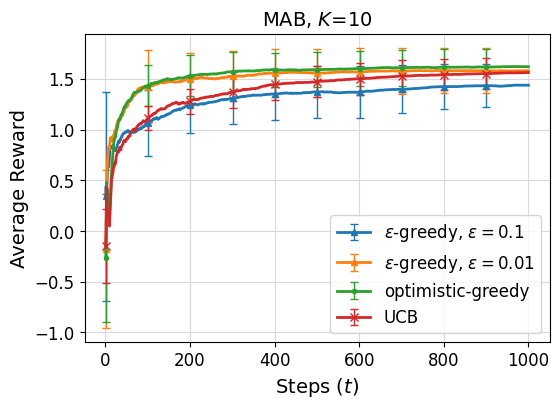

In [7]:
# DO NOT change any code in this cell

## Plotting script

fig = plt.figure(figsize=(6, 4))
plt.style.use('default')

steps=np.arange(1,T+1)
freq = int(T/10)

avg_reward_temp = total_reward/steps

avg_reward = avg_reward_temp.mean(axis=0)
sd_reward = avg_reward_temp.std(axis=0)

plt.errorbar(steps, avg_reward[0,:], sd_reward[0,:], errorevery=freq, marker='^', markevery=freq, label=r'$\epsilon$-greedy, $\epsilon = 0.1$', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[1,:], sd_reward[1,:], errorevery=freq, marker='^', markevery=freq, label=r'$\epsilon$-greedy, $\epsilon = 0.01$', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[2,:], sd_reward[2,:], errorevery=freq, marker='.', markevery=freq, label=r'optimistic-greedy', linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[3,:], sd_reward[3,:], errorevery=freq, marker='x', markevery=freq, label=r'UCB', linewidth=2, elinewidth=1, capsize=3)


plt.grid(color='0.85')
plt.xlabel('Steps ($t$)', size = 14)
plt.ylabel('Average Reward', size = 14)
plt.title(r'MAB, $K$={}'.format(K), size = 14)
plt.legend(loc='lower right', prop={'size': 12})
plt.tick_params(labelsize=12)

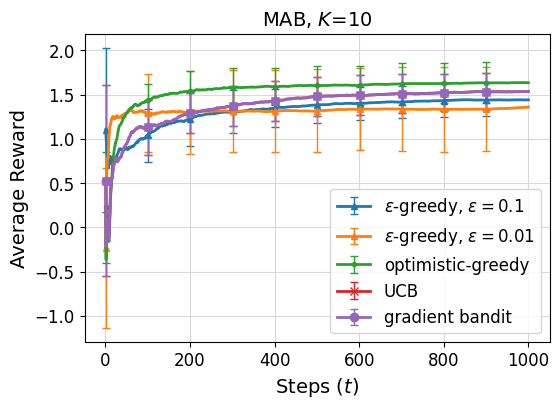

In [8]:
## Simulation

simul_n = 5 # Number of repetitions

for simul in range(simul_n):
    
    env = MAB(K)
            
    savename = "results/MAB_K={}_id={}.csv".format(K, simul) # make sure you have "results" folder to save your logs
    
    algos = []
    algos.append(epsilon_greedy(K,0.1))
    algos.append(epsilon_greedy(K,0.01))
    algos.append(optimistic_greedy(K))
    algos.append(UCB(K))
    algos.append(gradient_bandit(K))
    
    num_algos = len(algos)
    
    cumulated_reward = [ [] for _ in range(num_algos) ]
    rewards = [ [] for _ in range(num_algos) ]
    
    for t in range(1,T+1):

        for m in range(num_algos):
            a = algos[m].choose_a(t)
            reward = env.get_reward(a)
            rewards[m].append(reward)
            algos[m].update(reward,t)
            
    for m in range(num_algos):
        cumulated_reward[m].append(np.cumsum(rewards[m]))
    
    cumul_reward_array = np.vstack(cumulated_reward)
    np.savetxt(savename, cumul_reward_array, delimiter=",")




cumul_reward_list = []
for i in range(simul_n):
    cumul_reward_list.append(np.genfromtxt(
        "results/MAB_K={}_id={}.csv".format(K, i), delimiter=','))
        
total_reward = np.stack(cumul_reward_list)



fig = plt.figure(figsize=(6, 4))
plt.style.use('default')

steps=np.arange(1,T+1)
freq = int(T/10)

avg_reward_temp = total_reward/steps

avg_reward = avg_reward_temp.mean(axis=0)
sd_reward = avg_reward_temp.std(axis=0)

plt.errorbar(steps, avg_reward[0,:], sd_reward[0,:], errorevery=freq, marker='^', markevery=freq, label=r'$\epsilon$-greedy, $\epsilon = 0.1$', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[1,:], sd_reward[1,:], errorevery=freq, marker='^', markevery=freq, label=r'$\epsilon$-greedy, $\epsilon = 0.01$', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[2,:], sd_reward[2,:], errorevery=freq, marker='.', markevery=freq, label=r'optimistic-greedy', linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[3,:], sd_reward[3,:], errorevery=freq, marker='x', markevery=freq, label=r'UCB', linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reward[3,:], sd_reward[3,:], errorevery=freq, marker='o', markevery=freq, label=r'gradient bandit', linewidth=2, elinewidth=1, capsize=3)

plt.grid(color='0.85')
plt.xlabel('Steps ($t$)', size = 14)
plt.ylabel('Average Reward', size = 14)
plt.title(r'MAB, $K$={}'.format(K), size = 14)
plt.legend(loc='lower right', prop={'size': 12})
plt.tick_params(labelsize=12)

### Q1: Complete the codes for epsilon_greedy, optimistic_greedy, UCB algorithms.


I completed the code with epsilon_greedy, optimistic_greedy, UCB algorithms sucessfully.



### Q2: Which algorithm performs the best? You can tune hyper-parameters for each algorthms to improve the performances of the algorthms.

the optimistic greedy algorithm performs well typically.



### Q3: Write the code for "Gradient Bandit Algorithm" and compare with the algorithms above. Plot a new reward curve including the gradient bandit algorithm.

I add the gradient bandit algorithm and compare it with other 4 algorithms.

the optimistic greedy algorithm still shows stable good performance.

### Make sure to save your notebook file before submission!

Thank you!